# CSE 163 Final
Raj Duraisamy, Ethan Kawahara, Ethan Mizuno

## Imports

In [ ]:
!pip install pybaseball
!pip install scikit-learn
!pip install scikit-learn graphviz
!pip install matplotlib
!pip install plotly




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pybaseball as pyb
import matplotlib.cm as cm
import plotly.express as px




from pybaseball import playerid_reverse_lookup
from sklearn.datasets import load_iris, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns
















## Uploading Data

In [ ]:
#load in the pitch data for the last 3 year

statcast_data_2023 = pyb.statcast(start_dt='2023-03-31', end_dt='2023-9-30')
statcast_data_2022 = pyb.statcast(start_dt='2022-03-31', end_dt='2022-9-30')
statcast_data_2021 = pyb.statcast(start_dt='2021-03-31', end_dt='2021-9-30')
statcast_data_2020 = pyb.statcast(start_dt='2020-03-31', end_dt='2020-9-30')
statcast_data_2019 = pyb.statcast(start_dt='2019-03-31', end_dt='2019-9-30')

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 184/184 [02:55<00:00,  1.05it/s]


This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 184/184 [02:07<00:00,  1.44it/s]


This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 184/184 [03:00<00:00,  1.02it/s]


This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 70/70 [01:11<00:00,  1.03s/it]


This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 184/184 [02:51<00:00,  1.07it/s]


# Add the years to the data


In [ ]:
statcast_data_2023['year'] = 2023
statcast_data_2022['year'] = 2022
statcast_data_2021['year'] = 2021
statcast_data_2020['year'] = 2020
statcast_data_2019['year'] = 2019

all_data = [statcast_data_2023,
            statcast_data_2022,
            statcast_data_2021,
            statcast_data_2020,
            statcast_data_2019
            ]



# Function to set up the data
- Since the data only has the batterID number, use the playerid_reverse_lookup to find the name of the batter and add that in a column to the data
- Add a column to the data that makes a binary column that represents if the player got a hit or not
- Since the win expectancy change is only for the home team, need to find if the batter is home or away and flip the sign of the win expectancy change accordingly
- Get the abbreviation of the batting team using the inning

In [ ]:

def data_setup(df, clutch):

  look_up_result = playerid_reverse_lookup(df['batter'].tolist(), key_type='mlbam')

  df_merged = pd.DataFrame()

  df_merged = pd.merge(df, look_up_result[['key_mlbam', 'name_last', 'name_first']],left_on='batter', right_on='key_mlbam', how='left')

  events_to_keep = ["strikeout", "single", "double", "triple", "walk", "home_run", "field_out"]
  filtered_df = df_merged[df_merged['events'].isin(events_to_keep)]

  filtered_df['full_name'] = filtered_df['name_last'] + ", " + filtered_df['name_first']

  conditions = [
    filtered_df['events'].isin(['single', 'double', 'triple', 'walk', 'home_run']),
    filtered_df['events'] == 'strikeout'
  ]

  choices = [1, 0]

  filtered_df['hit'] = np.select(conditions, choices, default=np.nan)


  filtered_df['win_exp_change'] = filtered_df.apply(lambda row: -row['delta_home_win_exp'] if row['inning_topbot'] == 'Top' else row['delta_home_win_exp'], axis=1)

  filtered_df['batting_team_abbr'] = filtered_df.apply(lambda row: row['away_team'] if row['inning_topbot'] == 'Top' else row['home_team'], axis=1)

  if(clutch):
    filtered_df = filtered_df[(filtered_df['inning'] >= 8) & (abs(filtered_df['home_score'] - filtered_df['away_score']) <= 2)]


  return filtered_df







# Apply the data_setup function to the data.
- want to make the not_clutch and clutch data seperate


In [ ]:
data_2023 = data_setup(statcast_data_2023, True)
data_2022 = data_setup(statcast_data_2022, True)
data_2021 = data_setup(statcast_data_2021, True)
data_2020 = data_setup(statcast_data_2020, True)
data_2019 = data_setup(statcast_data_2019, True)

data_2023_not_clutch = data_setup(statcast_data_2023, False)
data_2022_not_clutch = data_setup(statcast_data_2022, False)
data_2021_not_clutch = data_setup(statcast_data_2021, False)
data_2020_not_clutch = data_setup(statcast_data_2020, False)
data_2019_not_clutch = data_setup(statcast_data_2019, False)







Gathering player lookup table. This may take a moment.


<ipython-input-6-532c32b4a2d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_name'] = filtered_df['name_last'] + ", " + filtered_df['name_first']
<ipython-input-6-532c32b4a2d4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hit'] = np.select(conditions, choices, default=np.nan)
<ipython-input-6-532c32b4a2d4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
length_2023 = len(statcast_data_2023)
length_2022 = len(statcast_data_2022)
length_2021 = len(statcast_data_2021)
length_2020 = len(statcast_data_2020)
length_2019 = len(statcast_data_2019)

total_length = length_2023 + length_2022 + length_2021 + length_2020 + length_2019
print("Total length of all datasets:", total_length)

Total length of all datasets: 3097458


In [ ]:
length_2023 = len(data_2023)
length_2022 = len(data_2022)
length_2021 = len(data_2021)
length_2020 = len(data_2020)
length_2019 = len(data_2019)
total_length = length_2023 + length_2022 + length_2021 + length_2020 + length_2019
print("Total length of all datasets:", total_length)


Total length of all datasets: 76106


In [ ]:
not_clutch_data =  [data_2019_not_clutch, data_2020_not_clutch, data_2021_not_clutch, data_2022_not_clutch, data_2023_not_clutch]

all_data = [data_2019, data_2020, data_2021, data_2022, data_2023]

all_data = pd.concat(all_data)

# Reset the index of the combined DataFrame
all_data.reset_index(drop=True, inplace=True)


In [ ]:
events_clutch = all_data[(all_data['inning'] > 7) & (abs(all_data['home_score'] - all_data['away_score']) < 2)]
len(events_clutch)

51347

# Give the data binary columns to determine if there are players on 1st, 2nd, or 3rd base


In [ ]:
events_clutch['on_first'] = 0.0
events_clutch.loc[events_clutch['on_1b'].notna(), 'on_first'] = 1.0
events_clutch['on_second'] = 0.0
events_clutch.loc[events_clutch['on_2b'].notna(), 'on_second'] = 1.0
events_clutch['on_third'] = 0.0
events_clutch.loc[events_clutch['on_3b'].notna(), 'on_third'] = 1.0

<ipython-input-214-04799341ec3d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-214-04799341ec3d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-214-04799341ec3d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Seperate the events by the outcome (single, double, triple, homerun, walk, K, or field out)

In [ ]:
events_clutch_single = events_clutch[events_clutch['events'] == 'single']
events_clutch_double = events_clutch[events_clutch['events'] == 'double']
events_clutch_triple = events_clutch[events_clutch['events'] == 'triple']
events_clutch_homerun = events_clutch[events_clutch['events'] == 'home_run']
events_clutch_walk = events_clutch[events_clutch['events'] == 'walk']
events_clutch_k = events_clutch[events_clutch['events'] == 'strikeout']
events_clutch_field_out = events_clutch[events_clutch['events'] == 'field_out']

all_clutch_events = [events_clutch_single, events_clutch_double, events_clutch_triple, events_clutch_homerun, events_clutch_walk, events_clutch_k, events_clutch_field_out]

# Separate the events by the number of outs


In [ ]:
events_clutch_one_out = events_clutch[(events_clutch["outs_when_up"] == 1) & ((events_clutch["hit"] == 1.0) | ((events_clutch["events"] == "strikeout") | (events_clutch['events'] == "field_out")))]
events_clutch_two_out = events_clutch[(events_clutch["outs_when_up"] == 2) & ((events_clutch["hit"] == 1.0) | ((events_clutch["events"] == "strikeout") | (events_clutch['events'] == "field_out")))]
events_clutch_zero_out = events_clutch[(events_clutch["outs_when_up"] == 2) & ((events_clutch["hit"] == 1.0) | ((events_clutch["events"] == "strikeout") | (events_clutch['events'] == "field_out")))]

# Iterates through the number of possible outs and create a key that is clutch_{num_outs}_out_{event_type}.

In [ ]:
event_types = ['single', 'double', 'triple', 'home_run', 'walk', 'strikeout', 'field_out']

clutch_outs_events = {}

for num_outs in range(3):
    current_outs_df = events_clutch[events_clutch["outs_when_up"] == num_outs]

    for event_type in event_types:
        key_name = f'clutch_{num_outs}_out_{event_type}'
        clutch_outs_events[key_name] = current_outs_df[current_outs_df['events'] == event_type]

# Find the count for every combination of events and outs


In [ ]:
data = {
    '0 Outs': [
        len(clutch_outs_events['clutch_0_out_single']), len(clutch_outs_events['clutch_0_out_double']), len(clutch_outs_events['clutch_0_out_triple']),
        len(clutch_outs_events['clutch_0_out_home_run']), len(clutch_outs_events['clutch_0_out_walk']), len(clutch_outs_events['clutch_0_out_strikeout']),
        len(clutch_outs_events['clutch_0_out_field_out'])
    ],
    '1 Out': [
        len(clutch_outs_events['clutch_1_out_single']), len(clutch_outs_events['clutch_1_out_double']), len(clutch_outs_events['clutch_1_out_triple']),
        len(clutch_outs_events['clutch_1_out_home_run']), len(clutch_outs_events['clutch_1_out_walk']), len(clutch_outs_events['clutch_1_out_strikeout']),
        len(clutch_outs_events['clutch_1_out_field_out'])
    ],
    '2 Outs': [
        len(clutch_outs_events['clutch_2_out_single']), len(clutch_outs_events['clutch_2_out_double']), len(clutch_outs_events['clutch_2_out_triple']),
        len(clutch_outs_events['clutch_2_out_home_run']), len(clutch_outs_events['clutch_2_out_walk']), len(clutch_outs_events['clutch_2_out_strikeout']),
        len(clutch_outs_events['clutch_2_out_field_out'])
    ]
}

# Event types as index
index = ['Single', 'Double', 'Triple', 'Home Run', 'Strikeout', 'Walk', 'Field Out']

# Creating the DataFrame
df_outcomes = pd.DataFrame(data, index=index)

df_outcomes

,0 Outs,1 Out,2 Outs
Single,2814,2541,2260
Double,736,691,601
Triple,65,57,50
Home Run,566,553,473
Strikeout,1700,1742,1781
Walk,4824,4850,4686
Field Out,7432,6151,6774


# Calculates the average change of win_exp for each event and out combination


In [ ]:
outs = [0, 1, 2]
events = ['single', 'double', 'triple', 'home_run', 'walk', 'strikeout', 'field_out']

mean_delta_win_exp = {out: {event: None for event in events} for out in outs}

for out in outs:
    for event in events:
        filtered_df = events_clutch[(events_clutch['outs_when_up'] == out) & (events_clutch['events'] == event)]
        mean_delta = filtered_df['win_exp_change'].mean()
        mean_delta_win_exp[out][event] = mean_delta

df_mean_delta_win_exp = pd.DataFrame.from_dict(mean_delta_win_exp, orient='index', columns=events)
df_mean_delta_win_exp.index = [f'{out} Outs' for out in outs]

(df_mean_delta_win_exp)

,single,double,triple,home_run,walk,strikeout,field_out
0 Outs,0.097040,0.165785,0.219938,0.280101,0.072541,-0.061929,-0.052062
1 Outs,0.102534,0.165724,0.262211,0.313703,0.055671,-0.064324,-0.050617
2 Outs,0.120360,0.175715,0.197160,0.396095,0.040556,-0.061278,-0.059962


# Gets the clutch rating and the scaled clutch rating (0-10) for a given year


In [ ]:
def get_clutch_rating(data):

  data['clutch_rating'] = data['win_exp_change']

  clutch_rating = data.groupby(['full_name', 'batting_team_abbr', 'year']).agg(
      total_clutch_rating=pd.NamedAgg(column='clutch_rating', aggfunc='sum'),
      count=pd.NamedAgg(column='clutch_rating', aggfunc='count')
  ).reset_index()


  original_min = clutch_rating['total_clutch_rating'].min()

  original_max = clutch_rating['total_clutch_rating'].max()

  new_min, new_max = 0, 10

  clutch_rating['scaled_total_clutch_rating'] = new_min + (
      (clutch_rating['total_clutch_rating'] - original_min) * (new_max - new_min) / (original_max - original_min)
  )
  return clutch_rating


# Gets the clutch rating for each year, adds alll the years together



In [ ]:
clutch_2019 = get_clutch_rating(data_2019)
clutch_2020 = get_clutch_rating(data_2020)
clutch_2021 = get_clutch_rating(data_2021)
clutch_2022 = get_clutch_rating(data_2022)
clutch_2023 = get_clutch_rating(data_2023)

all_clutch = pd.concat([clutch_2019, clutch_2020, clutch_2021, clutch_2022, clutch_2023], ignore_index=True)




# Gets the clutch rating for all the year (not clutch scenarios)

In [ ]:
not_clutch_2019_scaled = get_clutch_rating(data_2019_not_clutch)
not_clutch_2020_scaled = get_clutch_rating(data_2020_not_clutch)
not_clutch_2021_scaled = get_clutch_rating(data_2021_not_clutch)
not_clutch_2022_scaled = get_clutch_rating(data_2022_not_clutch)
not_clutch_2023_scaled = get_clutch_rating(data_2023_not_clutch)

not_all_clutch = pd.concat([not_clutch_2019_scaled, not_clutch_2020_scaled, not_clutch_2021_scaled, not_clutch_2022_scaled, not_clutch_2023_scaled], ignore_index=True)

# Top 10 clutch players and bottom 10 according to our metric


In [ ]:
sorted_clutch = all_clutch.sort_values(by='scaled_total_clutch_rating', ascending=False)
top_10_clutch = sorted_clutch[['full_name', 'batting_team_abbr', 'year', 'scaled_total_clutch_rating']].head(10)
top_10_clutch



,full_name,batting_team_abbr,year,scaled_total_clutch_rating
1957,"wade, lamonte",SF,2021,10.000000
3003,"harper, bryce",PHI,2023,10.000000
705,"yelich, christian",MIL,2019,10.000000
992,"laureano, ramón",OAK,2020,10.000000
2206,"estrada, thairo",SF,2022,10.000000
1194,"swanson, dansby",ATL,2020,9.946725
2339,"judge, aaron",NYY,2022,9.560850
1548,"hays, austin",BAL,2021,9.273294
2858,"carroll, corbin",AZ,2023,9.060587
309,"hicks, aaron",NYY,2019,8.996741


In [ ]:
sorted_clutch = all_clutch.sort_values(by='scaled_total_clutch_rating', ascending=False)

# Selecting the top 10 rows and only the specified columns
top_10_clutch = sorted_clutch[['full_name', 'batting_team_abbr', 'year', 'scaled_total_clutch_rating']].head(10)

top_10_clutch


,full_name,batting_team_abbr,year,scaled_total_clutch_rating
1957,"wade, lamonte",SF,2021,10.000000
3003,"harper, bryce",PHI,2023,10.000000
705,"yelich, christian",MIL,2019,10.000000
992,"laureano, ramón",OAK,2020,10.000000
2206,"estrada, thairo",SF,2022,10.000000
1194,"swanson, dansby",ATL,2020,9.946725
2339,"judge, aaron",NYY,2022,9.560850
1548,"hays, austin",BAL,2021,9.273294
2858,"carroll, corbin",AZ,2023,9.060587
309,"hicks, aaron",NYY,2019,8.996741


# Compared to the top 10 and bottom 10 players not in clutch scenarios


In [ ]:
sorted_not_clutch = not_all_clutch.sort_values(by='scaled_total_clutch_rating', ascending=False)
(sorted_not_clutch.head(10))


,full_name,batting_team_abbr,year,total_clutch_rating,count,scaled_total_clutch_rating
3652,"acuña, ronald",ATL,2023,7.207,669,10.000000
1045,"yelich, christian",MIL,2019,6.777,514,10.000000
1245,"freeman, freddie",ATL,2020,3.501,244,10.000000
2597,"soto, juan",WSH,2021,5.899,563,10.000000
3171,"judge, aaron",NYY,2022,8.456,627,10.000000
2059,"guerrero, vladimir",TOR,2021,5.682,632,9.740120
781,"rendon, anthony",WSH,2019,6.528,584,9.710600
2162,"judge, aaron",NYY,2021,5.513,580,9.537725
48,"arenado, nolan",COL,2019,6.228,592,9.361925
3914,"harper, bryce",PHI,2023,6.532,508,9.344151


# Finding the players with the biggest difference in clutch hitting v.s normal hitting (averaged over the past 5 years)


In [ ]:
not_clutch_average_rating = sorted_not_clutch.groupby('full_name')['scaled_total_clutch_rating'].mean().reset_index()
sorted_clutch_average_rating = sorted_clutch.groupby('full_name')['scaled_total_clutch_rating'].mean().reset_index()

average_rating_merged = pd.merge(not_clutch_average_rating, sorted_clutch_average_rating, on = ['full_name'], how = 'inner')
average_rating_merged['clutch_above_normal'] = average_rating_merged['scaled_total_clutch_rating_x'] - average_rating_merged['scaled_total_clutch_rating_y']


average_rating_merged = average_rating_merged.sort_values(by='clutch_above_normal', ascending=False)
average_rating_merged = average_rating_merged[['full_name', 'clutch_above_normal']]

average_rating_merged.head(5)


,full_name,clutch_above_normal
340,"freeman, freddie",3.248480
381,"goldschmidt, paul",2.844418
263,"devers, rafael",2.569426
3,"acuña, ronald",2.284192
747,"olson, matt",2.282248


Text(0.5, 1.0, 'Histogram of Clutch Rating - Normal Rating (Averaged for Years)')

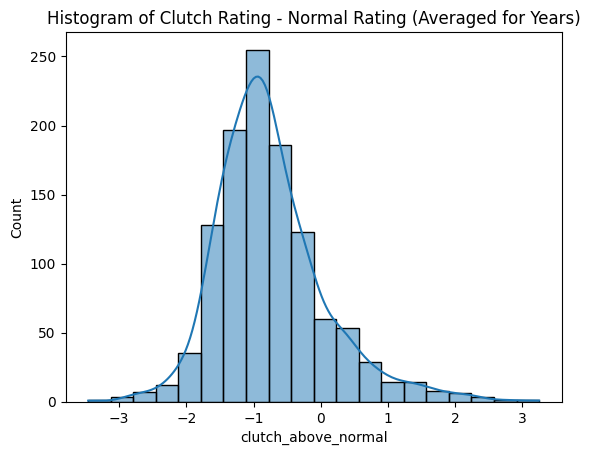

In [ ]:
sns.histplot(average_rating_merged['clutch_above_normal'], bins=20, kde=True)
plt.title('Histogram of Clutch Rating - Normal Rating (Averaged for Years)')


In [ ]:
average_rating_merged_year = pd.merge(sorted_clutch, sorted_not_clutch, on = ['full_name', 'year'], how = 'inner')

print(average_rating_merged_year['count_x'].median())

average_rating_merged_year = average_rating_merged_year[average_rating_merged_year['count_x'] > 14]
#Want to make sure there is no outliers that are affecting the data, the median amount of clutch moments is 14
average_rating_merged_year['clutch_above_normal'] = average_rating_merged_year['scaled_total_clutch_rating_x'] - average_rating_merged_year['scaled_total_clutch_rating_y']
average_rating_merged_year = average_rating_merged_year.sort_values(by='clutch_above_normal', ascending=False)
average_rating_merged_year = average_rating_merged_year[['full_name', 'clutch_above_normal', 'year']]

average_rating_merged_year.head(20)


14.0


,full_name,clutch_above_normal,year
12,"adames, willy",5.876190,2021
30,"garcía, avisaíl",5.276747,2022
53,"toro, abraham",5.231174,2022
93,"grossman, robbie",5.011476,2022
19,"alfaro, jorge",4.869523,2022
37,"stott, bryson",4.589260,2022
4,"estrada, thairo",4.385903,2022
52,"heim, jonah",4.335345,2021
44,"margot, manuel",4.199409,2022
226,"alcántara, sergio",3.964503,2022


<Axes: xlabel='clutch_above_normal', ylabel='Count'>

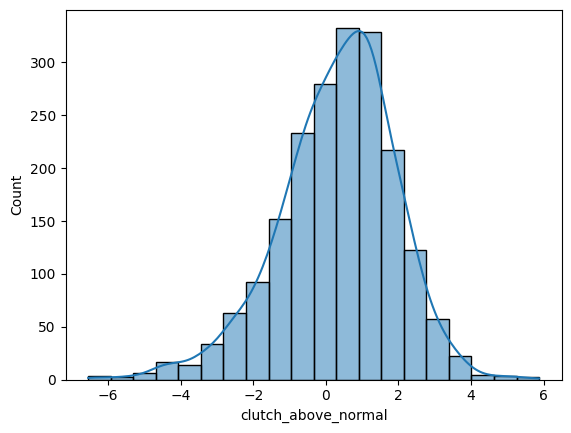

In [ ]:
sns.histplot(average_rating_merged_year['clutch_above_normal'], bins=20, kde=True)


# Group the data by team name and find the total clutch rating for a team


In [ ]:
def clutch_teams(data):
  clutch_rating_team = data.groupby('batting_team_abbr').agg(
      total_clutch_rating=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='sum'),
      count=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='count')).reset_index()


  clutch_rating_team['average_clutch_rating'] = clutch_rating_team['total_clutch_rating'] / clutch_rating_team['count']

  original_min = clutch_rating_team['average_clutch_rating'].min()

  original_max = clutch_rating_team['average_clutch_rating'].max()

  new_min, new_max = 0, 10

  clutch_rating_team['average_clutch_rating'] = new_min + (
      (clutch_rating_team['average_clutch_rating'] - original_min) * (new_max - new_min) / (original_max - original_min)
  )


  clutch_rating_team_sorted = clutch_rating_team.sort_values('average_clutch_rating', ascending=False)

  num_teams = len(clutch_rating_team_sorted)
  colors = cm.inferno(np.linspace(0, 1, num_teams))

  plt.figure(figsize = (10, 6))
  plt.bar(clutch_rating_team_sorted['batting_team_abbr'], clutch_rating_team_sorted['average_clutch_rating'], color = colors)
  plt.ylabel("Standardized Clutch Rating")
  plt.xlabel("Team Abbreviation")
  plt.xticks(rotation = 90)
  return clutch_rating_team_sorted



# Plotting all the players' scaled clutch rating over time


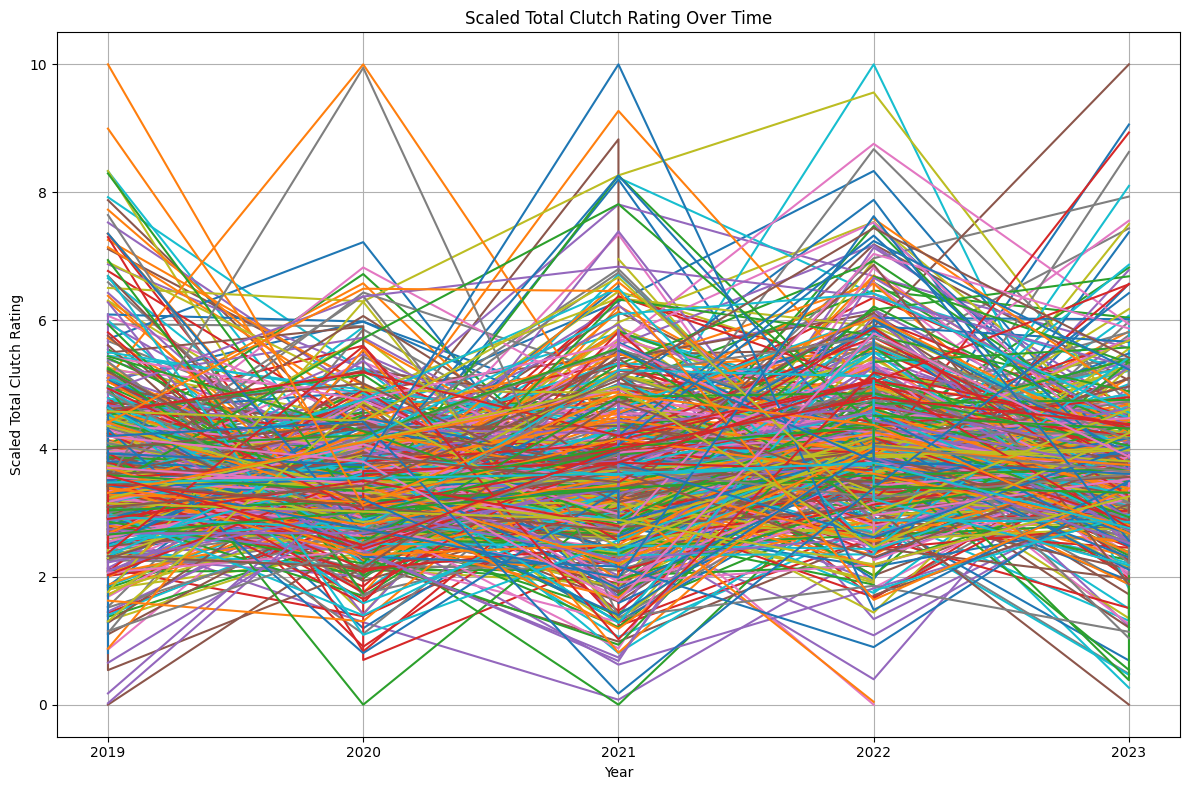

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 8))
unique_years = sorted(all_clutch['year'].unique())  # Get unique years and sort them


for player, data in all_clutch.groupby('full_name'):
    plt.plot(data['year'].astype(int), data['scaled_total_clutch_rating'], label=player)

plt.title('Scaled Total Clutch Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Total Clutch Rating')
plt.grid(True)
plt.xticks(unique_years)


plt.tight_layout()
plt.show()

# Scale for every year instead of just one year


In [ ]:

original_min = all_clutch['total_clutch_rating'].min()

original_max = all_clutch['total_clutch_rating'].max()

new_min, new_max = 0, 10

all_clutch['all_scaled_clutch_rating'] = new_min + (
      (all_clutch['total_clutch_rating'] - original_min) * (new_max - new_min) / (original_max - original_min)
)



# Top 20 player with both a scaled total anda all scaled clutch rating


In [ ]:
sorted_clutch = all_clutch.sort_values(by='all_scaled_clutch_rating', ascending=False)
(sorted_clutch.head(20))

,full_name,batting_team_abbr,year,total_clutch_rating,count,scaled_total_clutch_rating,all_scaled_clutch_rating
3003,"harper, bryce",PHI,2023,2.980,58,10.000000,10.000000
705,"yelich, christian",MIL,2019,2.761,62,10.000000,9.537877
2858,"carroll, corbin",AZ,2023,2.535,62,9.060587,9.060983
2206,"estrada, thairo",SF,2022,2.522,66,10.000000,9.033551
3257,"rosario, eddie",ATL,2023,2.476,35,8.936035,8.936484
1957,"wade, lamonte",SF,2021,2.436,39,10.000000,8.852078
2339,"judge, aaron",NYY,2022,2.334,72,9.560850,8.636843
3087,"lowe, josh",TB,2023,2.332,53,8.632046,8.632623
309,"hicks, aaron",NYY,2019,2.330,26,8.996741,8.628403
1548,"hays, austin",BAL,2021,2.156,41,9.273294,8.261237



# Worst 20 players

In [ ]:
sorted_clutch[['full_name', 'year', 'all_scaled_clutch_rating', 'scaled_total_clutch_rating']].tail(5)

,full_name,year,all_scaled_clutch_rating,scaled_total_clutch_rating
2283,"happ, ian",2022,0.358725,0.397103
2981,"grandal, yasmani",2023,0.267989,0.263880
2634,"stassi, max",2022,0.040093,0.044382
3311,"straw, myles",2023,0.004220,0.000000
2299,"hernández, césar",2022,0.000000,0.000000


In [ ]:
mean_value = sorted_clutch['all_scaled_clutch_rating'].mean()

# Calculate the standard deviation of the all_scaled_clutch_rating column
std_dev = sorted_clutch['all_scaled_clutch_rating'].std()

# Calculate the standard deviations away from the mean for each value
sorted_clutch['sd'] = (sorted_clutch['all_scaled_clutch_rating'] - mean_value) / std_dev
sorted_clutch = sorted_clutch.sort_values(by='all_scaled_clutch_rating', ascending=False)
sorted_clutch[['full_name', 'year', 'sd']].head()

,full_name,year,sd
3003,"harper, bryce",2023,6.039137
705,"yelich, christian",2019,5.595052
2858,"carroll, corbin",2023,5.136774
2206,"estrada, thairo",2022,5.110412
3257,"rosario, eddie",2023,5.017134


# Scaled clutch rating bar chart


Text(0.5, 1.0, 'Scaled Clutch Rating Counts')

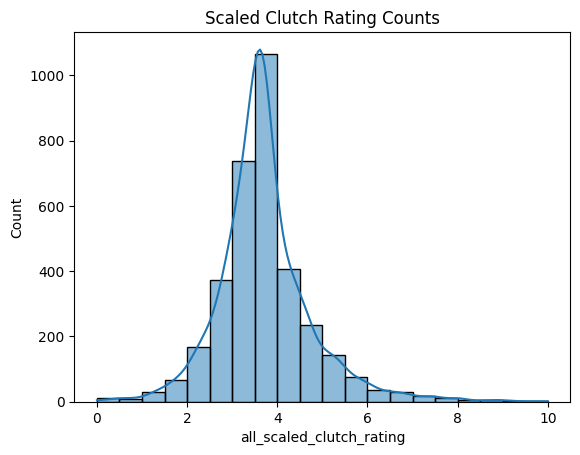

In [ ]:
# from matplotlib import pyplot as plt
# sorted_clutch['all_scaled_clutch_rating'].plot(kind='hist', bins=20, title='all_scaled_total_clutch_rating')
# plt.gca().spines[['top', 'right',]].set_visible(False)

sns.histplot(sorted_clutch['all_scaled_clutch_rating'], bins=20, kde=True)
plt.title("Scaled Clutch Rating Counts")

Text(0.5, 1.0, 'Only 2023 Scaled Clutch Rating Counts')

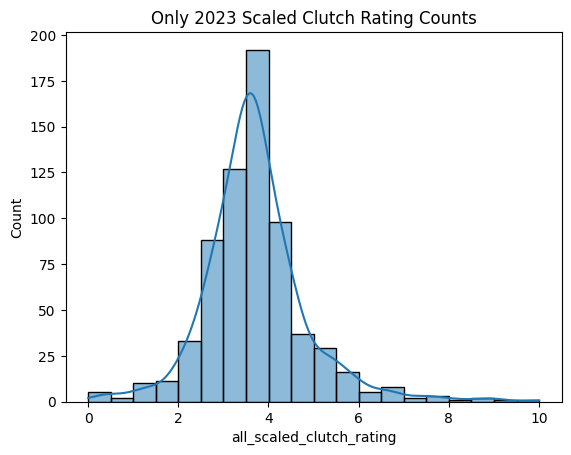

In [ ]:
sorted_clutch_2023 = sorted_clutch[sorted_clutch['year'] == 2023]
sns.histplot(sorted_clutch_2023['all_scaled_clutch_rating'], bins=20, kde=True)
plt.title("Only 2023 Scaled Clutch Rating Counts")

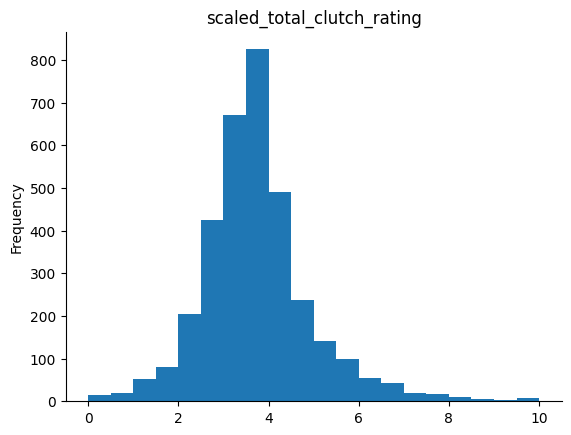

In [ ]:
from matplotlib import pyplot as plt
sorted_clutch['scaled_total_clutch_rating'].plot(kind='hist', bins=20, title='scaled_total_clutch_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Clutch teams bar chart

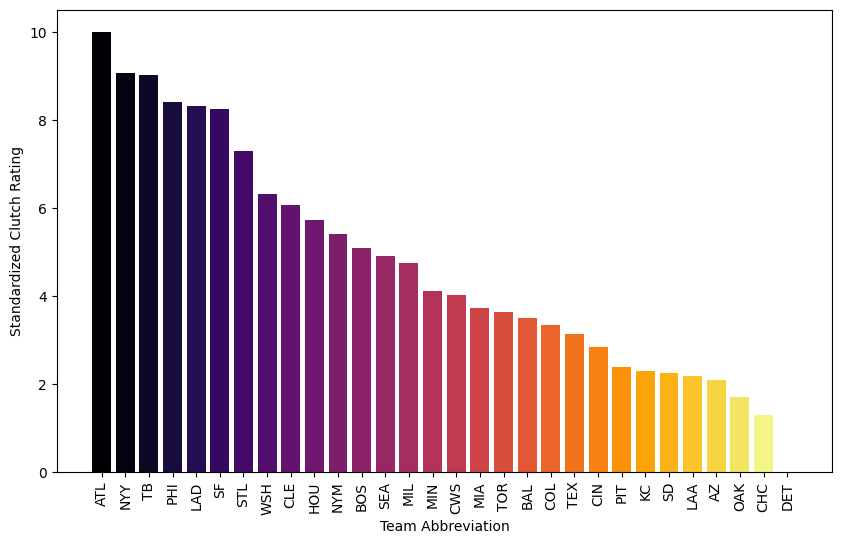

In [ ]:
most_clutch_teams = clutch_teams(all_clutch)

# Team abbreviations


In [ ]:
from pybaseball import schedule_and_record
from pybaseball import standings




team_abbreviations = {
    "Arizona Diamondbacks": "ARI",
    "Atlanta Braves": "ATL",
    "Baltimore Orioles": "BAL",
    "Boston Red Sox": "BOS",
    "Chicago White Sox": "CWS",
    "Chicago Cubs": "CHC",
    "Cincinnati Reds": "CIN",
    "Cleveland Guardians": "CLE",
    "Colorado Rockies": "COL",
    "Detroit Tigers": "DET",
    "Houston Astros": "HOU",
    "Kansas City Royals": "KC",
    "Los Angeles Angels": "LAA",
    "Los Angeles Dodgers": "LAD",
    "Miami Marlins": "MIA",
    "Milwaukee Brewers": "MIL",
    "Minnesota Twins": "MIN",
    "New York Yankees": "NYY",
    "New York Mets": "NYM",
    "Oakland Athletics": "OAK",
    "Philadelphia Phillies": "PHI",
    "Pittsburgh Pirates": "PIT",
    "San Diego Padres": "SD",
    "San Francisco Giants": "SF",
    "Seattle Mariners": "SEA",
    "St. Louis Cardinals": "STL",
    "Tampa Bay Rays": "TB",
    "Texas Rangers": "TEX",
    "Toronto Blue Jays": "TOR",
    "Washington Nationals": "WSH"
}





# Makes a dictionary of all the teams and their win totals and makes the keys the year

In [ ]:
def process_standings_for_year(year):
    data = standings(year)
    division_dfs = []
    for division_df in data:
        division_df['Abbreviation'] = division_df['Tm'].map(team_abbreviations)
        division_dfs.append(division_df)
    all_divisions_df = pd.concat(division_dfs, ignore_index=True)
    return all_divisions_df

all_years_df_dict = {}
years = [2019, 2020, 2021, 2022, 2023]


for year in years:
    all_years_df_dict[year] = process_standings_for_year(year)


all_years_df_dict

{2019:                        Tm    W    L  W-L%    GB Abbreviation
 0        New York Yankees  103   59  .636    --          NYY
 1          Tampa Bay Rays   96   66  .593   7.0           TB
 2          Boston Red Sox   84   78  .519  19.0          BOS
 3       Toronto Blue Jays   67   95  .414  36.0          TOR
 4       Baltimore Orioles   54  108  .333  49.0          BAL
 5         Minnesota Twins  101   61  .623    --          MIN
 6       Cleveland Indians   93   69  .574   8.0          NaN
 7       Chicago White Sox   72   89  .447  28.5          CWS
 8      Kansas City Royals   59  103  .364  42.0           KC
 9          Detroit Tigers   47  114  .292  53.5          DET
 10         Houston Astros  107   55  .660    --          HOU
 11      Oakland Athletics   97   65  .599  10.0          OAK
 12          Texas Rangers   78   84  .481  29.0          TEX
 13     Los Angeles Angels   72   90  .444  35.0          LAA
 14       Seattle Mariners   68   94  .420  39.0          SEA
 1

# Combines the dictionary into a dataframe

In [ ]:
modified_dfs = []

for year, df in all_years_df_dict.items():
    df_copy = df.copy()

    df_copy['year'] = year

    modified_dfs.append(df_copy)

combined_df = pd.concat(modified_dfs, ignore_index=True)
sorted_not_clutch = pd.concat(modified_dfs, ignore_index=True)



# Assigns the total_clutch_rating for not clutch situations to the batting_team_abbrev




In [ ]:
years = [2019, 2020, 2021, 2022, 2023]
not_clutch_rating_teams_yearly = []

for year in years:
  sorted_not_clutch = locals().get(f'clutch_{year}')
  clutch_rating_team = sorted_not_clutch.groupby('batting_team_abbr').agg(
      total_clutch_rating=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='sum'),
      count=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='count')).reset_index()
  clutch_rating_team['year'] = year
  not_clutch_rating_teams_yearly.append(clutch_rating_team)

not_clutch_rating_teams_all_years = pd.concat(not_clutch_rating_teams_yearly, ignore_index=True)

not_clutch_rating_teams_all_years

,batting_team_abbr,total_clutch_rating,count,year
0,ATL,89.897579,21,2019
1,AZ,83.531192,25,2019
2,BAL,72.974860,23,2019
3,BOS,84.967412,22,2019
4,CHC,94.855680,27,2019
...,...,...,...,...
145,STL,89.202027,24,2023
146,TB,93.863205,21,2023
147,TEX,66.533671,19,2023
148,TOR,67.175427,19,2023


# Combines the dataframes if the team abbreviation and year matches. Make the wins column into integers as well

In [ ]:
not_clutch = pd.merge(not_clutch_rating_teams_all_years, combined_df,
                     left_on=['batting_team_abbr', 'year'],
                     right_on=['Abbreviation', 'year'],
                     how='right')


not_clutch['W'] = not_clutch['W'].astype(int)

# Assigns the total_clutch_rating for all years to the batting_team_abbrev

In [ ]:
years = [2019, 2020, 2021, 2022, 2023]
clutch_rating_teams_yearly = []

for year in years:
  clutch_df = locals().get(f'clutch_{year}')
  clutch_rating_team = clutch_df.groupby('batting_team_abbr').agg(
      total_clutch_rating=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='sum'),
      count=pd.NamedAgg(column='scaled_total_clutch_rating', aggfunc='count')).reset_index()
  clutch_rating_team['year'] = year
  clutch_rating_teams_yearly.append(clutch_rating_team)

clutch_rating_teams_all_years = pd.concat(clutch_rating_teams_yearly, ignore_index=True)

clutch_rating_teams_all_years

,batting_team_abbr,total_clutch_rating,count,year
0,ATL,89.897579,21,2019
1,AZ,83.531192,25,2019
2,BAL,72.974860,23,2019
3,BOS,84.967412,22,2019
4,CHC,94.855680,27,2019
...,...,...,...,...
145,STL,89.202027,24,2023
146,TB,93.863205,21,2023
147,TEX,66.533671,19,2023
148,TOR,67.175427,19,2023


# Merge the data if the batting abbreviation and the year matches. Make the wins column into integers as well

In [ ]:
merged_df = pd.merge(clutch_rating_teams_all_years, combined_df,
                     left_on=['batting_team_abbr', 'year'],
                     right_on=['Abbreviation', 'year'],
                     how='right')


merged_df['W'] = merged_df['W'].astype(int)


Text(0.5, 0, 'team clutch rating')

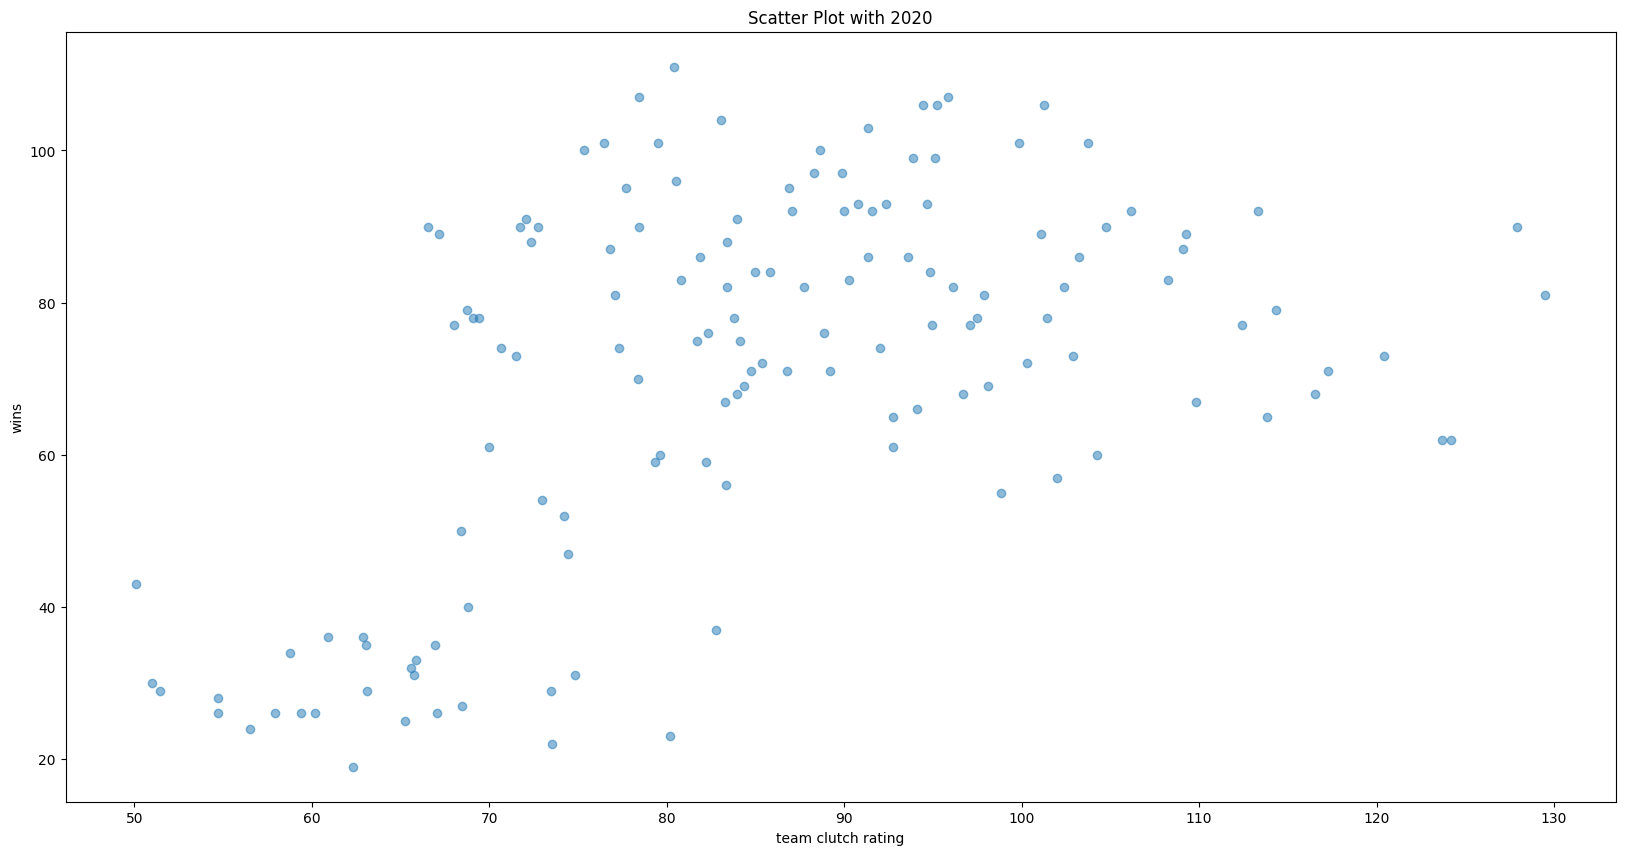

In [ ]:
plt.figure(figsize=(20, 10))  # Set the figure size for better visibility
plt.scatter(x = not_clutch['total_clutch_rating'], y = not_clutch['W'], alpha=0.5)
plt.title("Scatter Plot with 2020")
plt.ylabel("wins")
plt.xlabel("team clutch rating")

# Seperate the data to include and not include 2020 (beacuse of the shortened season)

In [ ]:
clutch_data = merged_df
without_2020_clutch = merged_df[merged_df['year'] != 2020]


#not clutch scenario
without_2020_not_clutch = not_clutch[not_clutch['year'] != 2020]
not_clutch


,batting_team_abbr,total_clutch_rating,count,year,Tm,W,L,W-L%,GB,Abbreviation
0,NYY,91.364060,23.0,2019,New York Yankees,103,59,.636,--,NYY
1,TB,80.526071,23.0,2019,Tampa Bay Rays,96,66,.593,7.0,TB
2,BOS,84.967412,22.0,2019,Boston Red Sox,84,78,.519,19.0,BOS
3,TOR,83.303073,23.0,2019,Toronto Blue Jays,67,95,.414,36.0,TOR
4,BAL,72.974860,23.0,2019,Baltimore Orioles,54,108,.333,49.0,BAL
...,...,...,...,...,...,...,...,...,...,...
145,LAD,75.362043,20.0,2023,Los Angeles Dodgers,100,62,.617,--,LAD
146,NaN,NaN,NaN,2023,Arizona Diamondbacks,84,78,.519,16.0,ARI
147,SD,83.407220,24.0,2023,San Diego Padres,82,80,.506,18.0,SD
148,SF,114.357188,29.0,2023,San Francisco Giants,79,83,.488,21.0,SF


Text(0.5, 0, 'team clutch rating')

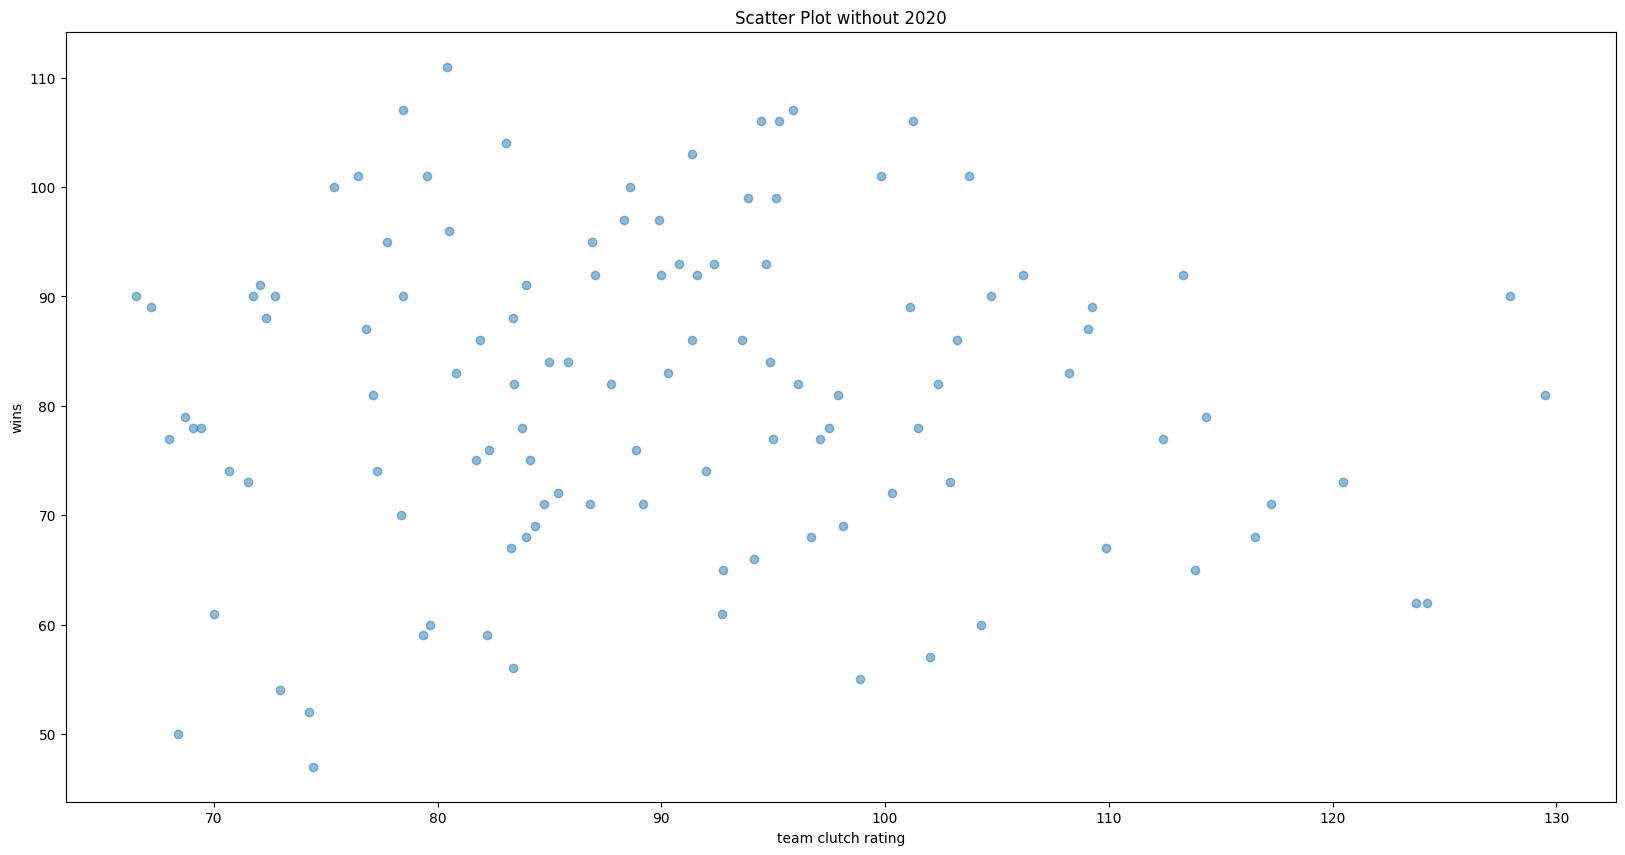

In [ ]:
plt.figure(figsize=(20, 10))  # Set the figure size for better visibility
plt.scatter(x = without_2020_clutch['total_clutch_rating'], y = without_2020_clutch['W'], alpha=0.5)
plt.title("Scatter Plot without 2020")
plt.ylabel("wins")
plt.xlabel("team clutch rating")



Text(0.5, 0, 'team clutch rating')

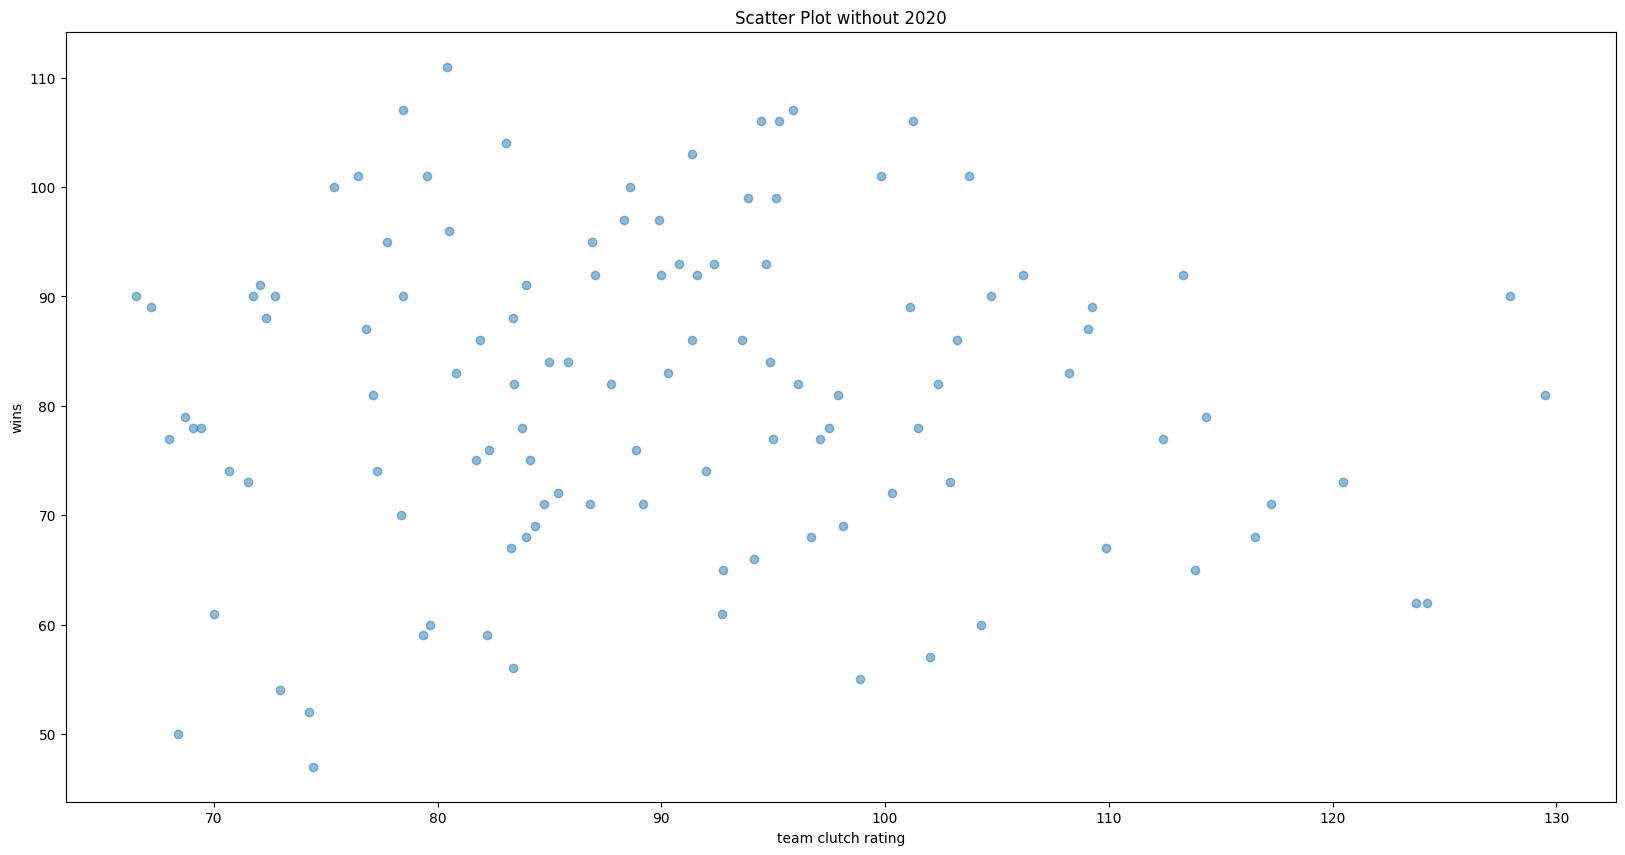

In [ ]:
plt.figure(figsize=(20, 10))  # Set the figure size for better visibility
plt.scatter(x = without_2020_not_clutch['total_clutch_rating'], y = without_2020_clutch['W'], alpha=0.5)
plt.title("Scatter Plot without 2020")
plt.ylabel("wins")
plt.xlabel("team clutch rating")


In [ ]:
fig = px.scatter(not_clutch, x='total_clutch_rating', y='W',
                 title='team win prob added  vs. Wins',
                 hover_data=['batting_team_abbr', 'year'])  # assuming you want to show team abbreviations on hover

# Show the figure
fig.show()

In [ ]:
# Create an interactive scatter plot with the filtered DataFrame
fig = px.scatter(without_2020_not_clutch, x='total_clutch_rating', y='W',
                 title='Total Clutch Rating vs. Wins (Excluding 2020)',
                 hover_data=['batting_team_abbr', 'year'])  # Adjust hover_data as needed

# Show the figure
fig.show()

# Create the plot that shows the variablity of the batter

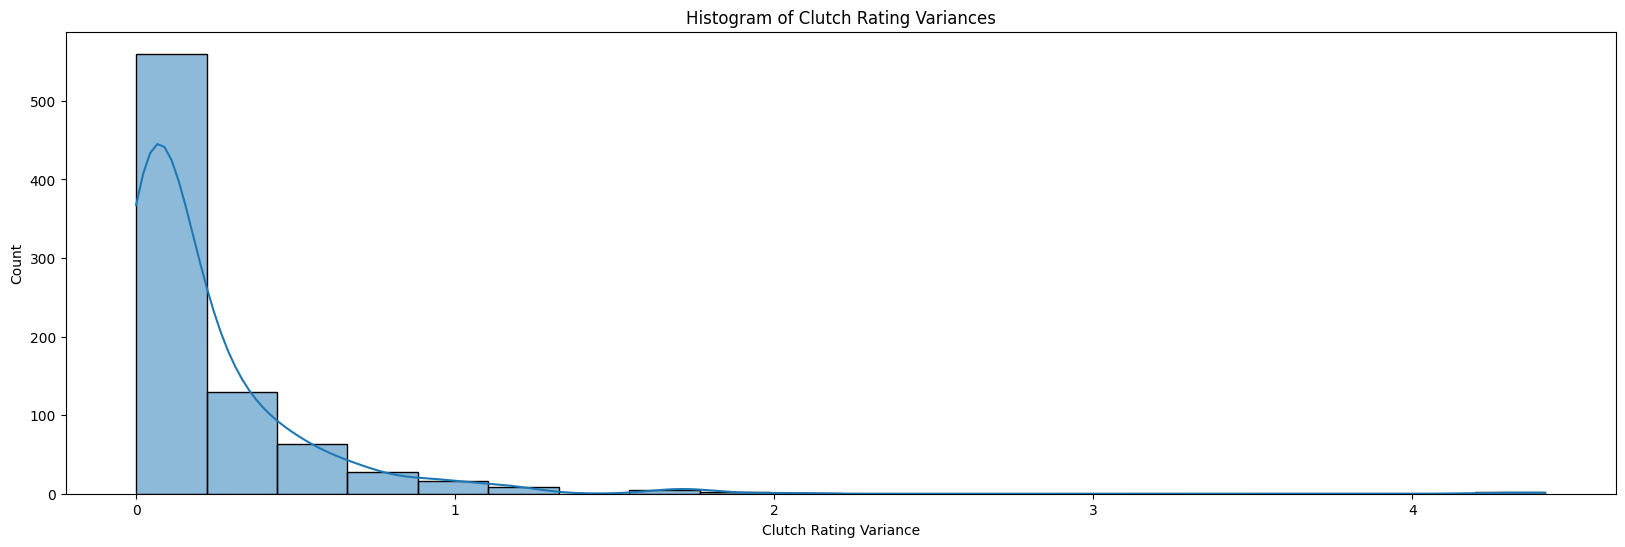

In [ ]:
variance_df = sorted_clutch.groupby('full_name')['total_clutch_rating'].var().reset_index(name='clutch_rating_variance')

sorted_merged_df = pd.merge(sorted_clutch, variance_df, on='full_name', how='left')

plt.figure(figsize=(20, 6))

sns.histplot(variance_df['clutch_rating_variance'], bins=20, kde=True)

plt.xlabel('Clutch Rating Variance')
plt.title('Histogram of Clutch Rating Variances')

plt.show()  # Display the plot



# Testing for batter variability for just one year, graph looks almost the same


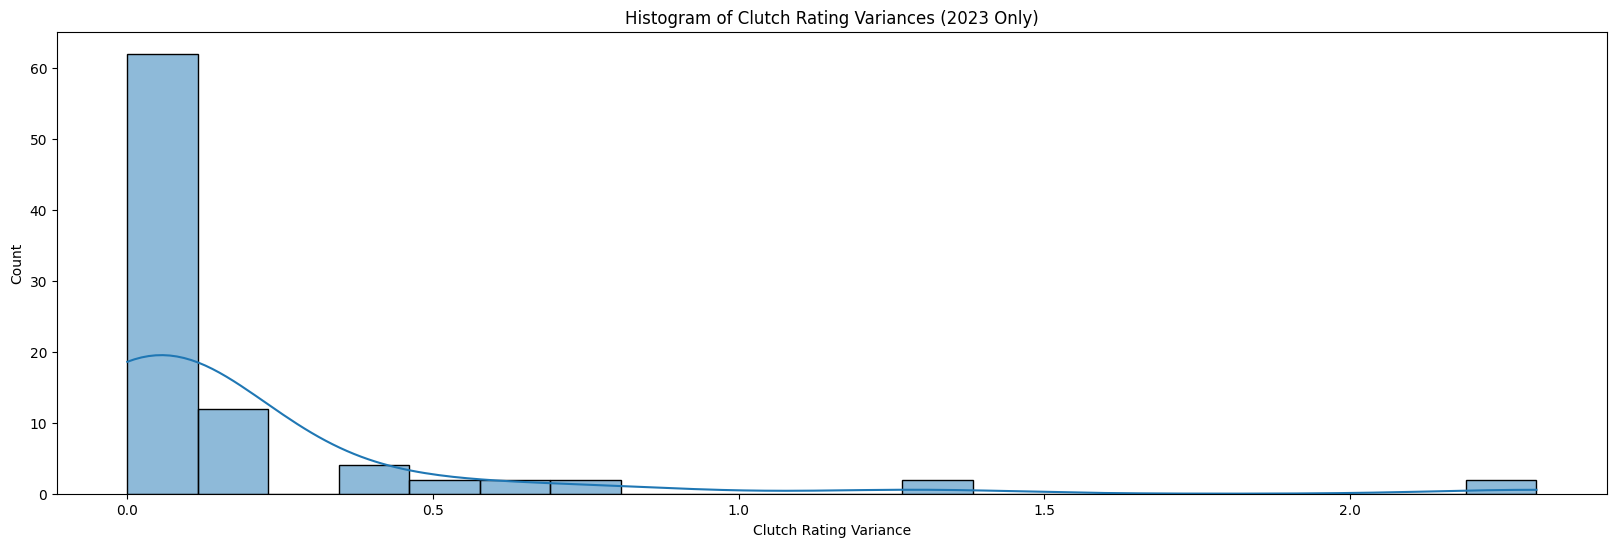

In [ ]:
sorted_clutch_2023 = sorted_clutch[sorted_clutch['year'] == 2023]
variance_df_2023 = sorted_clutch_2023.groupby('full_name')['total_clutch_rating'].var().reset_index(name='clutch_rating_variance')

sorted_merged_df_2023 = pd.merge(sorted_clutch_2023, variance_df_2023, on='full_name', how='left')

plt.figure(figsize=(20, 6))

sns.histplot(sorted_merged_df_2023['clutch_rating_variance'], bins=20, kde=True)

plt.xlabel('Clutch Rating Variance')
plt.title('Histogram of Clutch Rating Variances (2023 Only)')

plt.show()  # Display the plot

# Looks thrugh each year and formats the Excel spreadsheet to match the file name format. Gets each excel spreadsheet into a dataframe


In [ ]:
dataframes = {}

# Loop through each year from 2019 to 2023
for year in range(2019, 2024):
    # Format the Excel and CSV file names based on the current year
    excel_file = f"{year}_payroll.xlsx"
    csv_file = f"{year}_payroll.csv"

    # Read the Excel file
    df = pd.read_excel(excel_file)

    # Save the DataFrame to CSV
    df.to_csv(csv_file, index=False)

    # Store the DataFrame in the dictionary with the year as the key
    dataframes[f"{year}_payroll_df"] = df

payroll_2019_df = dataframes["2019_payroll_df"]
payroll_2020_df = dataframes["2020_payroll_df"]
payroll_2021_df = dataframes["2021_payroll_df"]
payroll_2022_df = dataframes["2022_payroll_df"]
payroll_2023_df = dataframes["2023_payroll_df"]


# Add a year column to each seperate data set

In [ ]:
payroll_2019_df['year'] = 2019
payroll_2020_df['year'] = 2020
payroll_2021_df['year'] = 2021
payroll_2022_df['year'] = 2022
payroll_2023_df['year'] = 2023

# Concatenate all the seperate payroll dataframe together

In [ ]:
all_years_payroll_df = pd.concat([
    payroll_2019_df,
    payroll_2020_df,
    payroll_2021_df,
    payroll_2022_df,
    payroll_2023_df
])

all_years_payroll_df

,team name,roster,league,division,team payroll,w,l,wpct,rank,lgrk,mlb rk,last yr payroll,top salary,year
0,Boston Red Sox,team roster,AL,East,222171123,84,78,0.519,3,7,15,235649368,David Price (5),2019
1,Chicago Cubs,team roster,NL,Central,210358488,84,78,0.519,3,8,14,183463459,Jon Lester (12),2019
2,New York Yankees,team roster,AL,East,208084848,103,59,0.636,1,2,3,168541038,Giancarlo Stanton (13),2019
3,Los Angeles Dodgers,team roster,NL,West,196729548,106,56,0.654,1,1,2,186138211,Clayton Kershaw (5),2019
4,San Francisco Giants,team roster,NL,West,178286222,77,85,0.475,3,10,18,208509901,Johnny Cueto (22),2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Cincinnati Reds,team roster,NL,Central,70624500,82,80,0.506,3,9,17,113580000,Joey Votto (25),2023
26,Tampa Bay Rays,team roster,AL,East,64652911,99,63,0.611,2,2,4,75347813,Zach Eflin (123),2023
27,Pittsburgh Pirates,team roster,NL,Central,60787500,76,86,0.469,4,11,21,38575000,Ke'Bryan Hayes (136),2023
28,Baltimore Orioles,team roster,AL,East,52157966,101,61,0.623,1,1,2,41421166,James McCann (113),2023


# Merge the payrolls and the team record data together if the team name and year match

In [ ]:
merged_with_payroll_df = pd.merge(all_years_payroll_df, merged_df, left_on=['team name', 'year'], right_on=['Tm', 'year'])
merged_with_payroll_df



,team name,roster,league,division,team payroll,w,l,wpct,rank,lgrk,...,year,batting_team_abbr,total_clutch_rating,count,Tm,W,L,W-L%,GB,Abbreviation
0,Boston Red Sox,team roster,AL,East,222171123,84,78,0.519,3,7,...,2019,BOS,84.967412,22.0,Boston Red Sox,84,78,.519,19.0,BOS
1,Chicago Cubs,team roster,NL,Central,210358488,84,78,0.519,3,8,...,2019,CHC,94.855680,27.0,Chicago Cubs,84,78,.519,7.0,CHC
2,New York Yankees,team roster,AL,East,208084848,103,59,0.636,1,2,...,2019,NYY,91.364060,23.0,New York Yankees,103,59,.636,--,NYY
3,Los Angeles Dodgers,team roster,NL,West,196729548,106,56,0.654,1,1,...,2019,LAD,94.459963,22.0,Los Angeles Dodgers,106,56,.654,--,LAD
4,San Francisco Giants,team roster,NL,West,178286222,77,85,0.475,3,10,...,2019,SF,112.418529,32.0,San Francisco Giants,77,85,.475,29.0,SF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Cincinnati Reds,team roster,NL,Central,70624500,82,80,0.506,3,9,...,2023,CIN,96.115685,25.0,Cincinnati Reds,82,80,.506,10.0,CIN
146,Tampa Bay Rays,team roster,AL,East,64652911,99,63,0.611,2,2,...,2023,TB,93.863205,21.0,Tampa Bay Rays,99,63,.611,2.0,TB
147,Pittsburgh Pirates,team roster,NL,Central,60787500,76,86,0.469,4,11,...,2023,PIT,88.864260,25.0,Pittsburgh Pirates,76,86,.469,16.0,PIT
148,Baltimore Orioles,team roster,AL,East,52157966,101,61,0.623,1,1,...,2023,BAL,79.527127,20.0,Baltimore Orioles,101,61,.623,--,BAL


# Standardize the scaled payroll for a given year to adjust for inflation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#transform makes it so it applies to each group seperatly
#reshapes the values to be in a. 2d array with a single column rather than just a 1d array

merged_with_payroll_df['scaled_payroll'] = merged_with_payroll_df.groupby(['year'])['team payroll'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())


# Ploting the total clutch rating of a team against the total wins of the team. The scaled payroll of the team determines the shade of the point.

In [ ]:
fig = px.scatter(merged_with_payroll_df, x='total_clutch_rating', y='W',
                 title='team_clutch_rating vs wins with scaled payroll per year',
                 hover_data=['batting_team_abbr', 'year'],
                 color = 'scaled_payroll')  # assuming you want to show team abbreviations on hover

# Show the figure
fig.show()

# Plotting the plotly graph with payroll included as the color. The payroll is scaled

In [ ]:
without_2020_merged_with_payroll = merged_with_payroll_df[merged_with_payroll_df['year'] != 2020]
fig = px.scatter(without_2020_merged_with_payroll, x='total_clutch_rating', y='W',
                 title='team_clutch_rating vs wins with scaled payroll per year',
                 hover_data=['batting_team_abbr', 'year'],
                 color = 'scaled_payroll')  # assuming you want to show team abbreviations on hover

# Show the figure
fig.update_traces(marker=dict(size=12))
fig.show()
